In [2]:
import scipy
import random
import portpy.photon as pp
import numpy as np
from cvxpy import *
from scipy import sparse
import sklearn.metrics
import cProfile
import time
import sys
import psutil
from sklearn.decomposition import PCA
import cvxpy as cp
import matplotlib.pyplot as plt

In [6]:
# specify the patient data location.
data_dir = r'../data'
# Use PortPy DataExplorer class to explore PortPy data
data = pp.DataExplorer(data_dir=data_dir)
# display the existing patients in console or browser.
data.display_list_of_patients()

,patient_id,disease_site,ptv_vol_cc,num_beams
0,Lung_Phantom_Patient_1,Lung,43.902,72


In [7]:
# pick a patient from the existing patient list to get detailed info (e.g., beam angles, structures).
data.patient_id = 'Lung_Phantom_Patient_1'
# display the data of the patient in console or browser.
beams_df, structs_df = data.display_patient_metadata(return_beams_df=True, return_structs_df=True)
beams_df.head()

,ID,gantry_angle,collimator_angle,couch_angle,beam_modality,energy_MV,influence_matrix(sparse/full),iso_center,MLC_name,machine_name
0,0,0,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
1,1,5,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
2,2,10,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
3,3,15,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
4,4,20,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM


In [8]:
structs_df.head()

,name,volume_cc
0,GTV,27.629362
1,LUNGS_NOT_GTV,2983.244630
2,PTV,43.901787
3,CORD,5.307685
4,HEART,841.405457


In [4]:
# Load ct and structure set for the above patient using CT and Structures class
ct = pp.CT(data)
structs = pp.Structures(data)

# If the list of beams are not provided, it uses the beams selected manually
# by a human expert planner for the patient (manually selected beams are stored in portpy data).
# Create beams for the planner beams by default
# for the customized beams, you can pass the argument beam_ids
# e.g. beams = pp.Beams(data, beam_ids=[0,10,20,30,40,50,60])
beams = pp.Beams(data)


# create rinds based upon rind definition in optimization params
protocol_name = 'Lung_2Gy_30Fx'
opt_params = data.load_config_opt_params(protocol_name=protocol_name)
structs.create_opt_structures(opt_params=opt_params)

# load influence matrix based upon beams and structure set
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

# load clinical criteria from the config files for which plan to be optimized
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)

creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done


In [5]:
# create a plan using ct, structures, beams and influence matrix. Clinical criteria is optional
my_plan = pp.Plan(ct, structs, beams, inf_matrix, clinical_criteria)

# create cvxpy problem using the clinical criteria and optimization parameters
opt = pp.Optimization(my_plan, opt_params=opt_params)
opt.create_cvxpy_problem()

Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done


In [5]:
sol = opt.solve(solver='MOSEK', verbose=True)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Dec 17 03:14:43 PM: Your problem has 1946 variables, 14 constraints, and 0 parameters.
(CVXPY) Dec 17 03:14:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 17 03:14:43 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 17 03:14:43 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 17 03:14:43 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Dec 17 03:14:43 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

(CVXPY) Dec 17 03:14:52 PM: Optimizer terminated. Time: 3.83    
(CVXPY) Dec 17 03:14:52 PM: 
(CVXPY) Dec 17 03:14:52 PM: 
(CVXPY) Dec 17 03:14:52 PM: Interior-point solution summary
(CVXPY) Dec 17 03:14:52 PM:   Problem status  : PRIMAL_AND_DUAL_FEASIBLE
(CVXPY) Dec 17 03:14:52 PM:   Solution status : OPTIMAL
(CVXPY) Dec 17 03:14:52 PM:   Primal.  obj: 4.2045448085e+01    nrm: 1e+02    Viol.  con: 6e-06    var: 2e-06    cones: 0e+00  
(CVXPY) Dec 17 03:14:52 PM:   Dual.    obj: 4.2045448063e+01    nrm: 6e+03    Viol.  con: 0e+00    var: 8e-07    cones: 0e+00  
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Dec 17 03:14:52 PM: Problem status: optimal
(CVXPY) Dec 17 03:14:52 PM: Optimal value: 4.205e+01
(CVXPY) Dec 17 03:14:52 PM: Compilation took 3.168e+00 seconds
(CVXPY) Dec 17 03:14:52 

<Axes: xlabel='x-axis (beamlets column)', ylabel='y-axis (beamlets row)'>

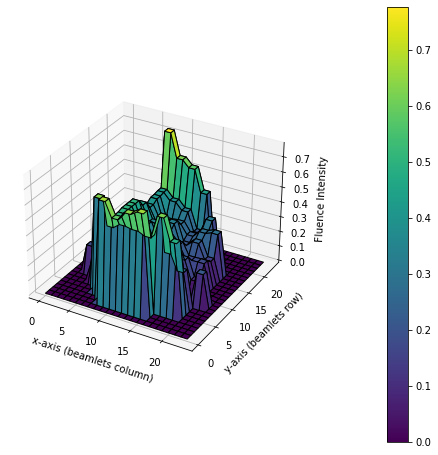

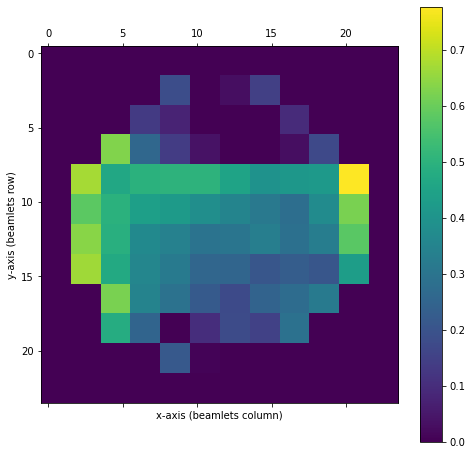

In [7]:
# plot fluence 3d and 2d for the 1st beam
pp.Visualization.plot_fluence_3d(sol=sol, beam_id=my_plan.beams.get_all_beam_ids()[0])

pp.Visualization.plot_fluence_2d(sol=sol, beam_id=my_plan.beams.get_all_beam_ids()[0])


<Axes: title={'center': 'Lung_Phantom_Patient_1'}, xlabel='Dose (Gy)', ylabel='Volume Fraction (%)'>

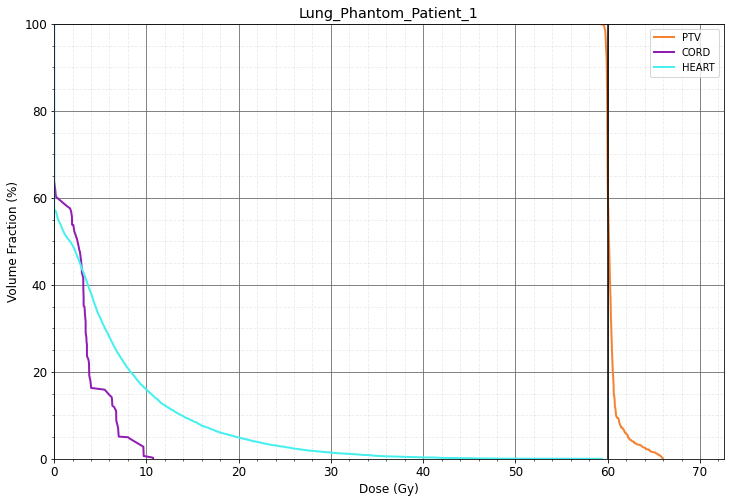

In [8]:
# plot dvh for the structures in the given list. Default dose_1d is in Gy and volume is in relative scale(%).
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']

# plot dvh for the above structures
pp.Visualization.plot_dvh(my_plan, sol=sol, struct_names=struct_names, title=data.patient_id)


<Axes: title={'center': 'Axial View - Slice #: 60'}>

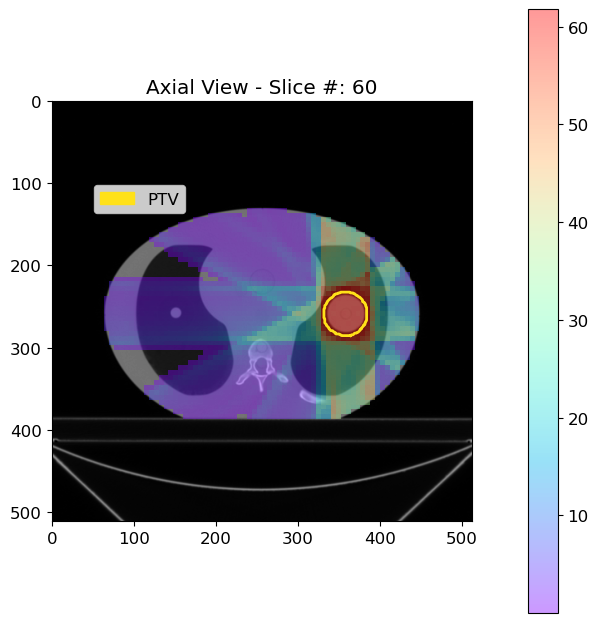

In [9]:
# plot 2d axial slice for the given solution and display the structures contours on the slice
pp.Visualization.plot_2d_slice(my_plan=my_plan, sol=sol, slice_num=60, struct_names=['PTV'])

In [10]:
# visualize plan metrics based upon clinical criteria
pp.Evaluation.display_clinical_criteria(my_plan, sol=sol)

,name,parameters,constraints,Plan Value
0,max_dose,{'structure_name': 'GTV'},"{'limit_dose_gy': 69, 'goal_dose_gy': 66}",65.960514
1,max_dose,{'structure_name': 'PTV'},"{'limit_dose_gy': 69, 'goal_dose_gy': 66}",65.960514
2,max_dose,{'structure_name': 'HEART'},{'limit_dose_gy': 66},59.355849
3,mean_dose,{'structure_name': 'HEART'},"{'limit_dose_gy': 27, 'goal_dose_gy': 20}",4.756942
4,dose_volume_V,"{'structure_name': 'HEART', 'dose_gy': 30}",{'limit_volume_perc': 50},1.433085
5,dose_volume_V,"{'structure_name': 'HEART', 'dose_gy': 30}",{'goal_volume_perc': 48},1.433085
6,max_dose,{'structure_name': 'LUNG_L'},{'limit_dose_gy': 66},65.960514
7,max_dose,{'structure_name': 'LUNG_R'},{'limit_dose_gy': 66},25.474999
8,max_dose,{'structure_name': 'CORD'},"{'limit_dose_gy': 50, 'goal_dose_gy': 48}",10.729736
9,max_dose,{'structure_name': 'SKIN'},{'limit_dose_gy': 60},50.963987
